# CNN Cancer Detection

The goal of this assignment is to detect cancer detection from pathology scans using convolutional neural networks. I'm going to try multiple convolutional neural networks and then decide which one is best.

## Import statements

In [1]:
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
import matplotlib.patches as patches


from tifffile import imread

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [41]:
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.metrics import AUC

## EDA

The dataset I'm using has 220k images of training data with labels for all of them. That gives us a sufficient amount of data to train the model with. There is a dataset with the file names of images as well as the label. The test data does not have labels.

Since I used Kaggle to create this notebook, I used the paths from kaggle. If you're running this locally, you may want to change the directory paths.

In [2]:
test_path = '/kaggle/input/histopathologic-cancer-detection/test/'
train_path = '/kaggle/input/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
train_data = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

Let us look at what the training labels look like.

In [3]:
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


It appears the dataset consists of the file name without the exception, and a binary label specifying whether the patient has cancer. Let us add another field that specifies the file name with the extension, just to make the dataset easier to work with.

In [5]:
images_train = train_data
images_train['label'] = images_train['label'].astype(str)
images_train['file'] = train_data['id'] + '.tif'
images_train.head()

,id,label,file
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


This might also be a good time to compare the number of patients that do have cancer and the number that don't, from our dataset.

<Axes: >

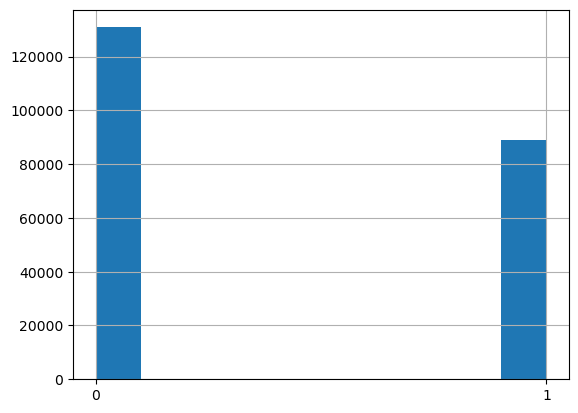

In [7]:
images_train['label'].hist()

I'm curious to know what the images for people that do have cancer look like, in comparison to the ones that don't. So let us separate the dataset by this condition.

In [12]:
cancer_images = images_train.loc[images_train['label']=='1'].reset_index()
noncancer_images = images_train.loc[images_train['label']=='0'].reset_index()
cancer_images.head()

,index,id,label,file
0,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
1,6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da.tif
2,7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1,7f6ccae485af121e0b6ee733022e226ee6b0c65f.tif
3,11,c3d660212bf2a11c994e0eadff13770a9927b731,1,c3d660212bf2a11c994e0eadff13770a9927b731.tif
4,14,94fa32b29cc1c00403176c0795fffa3cfaa0f20e,1,94fa32b29cc1c00403176c0795fffa3cfaa0f20e.tif


Now let's generate a few images of the patients that do have cancer.

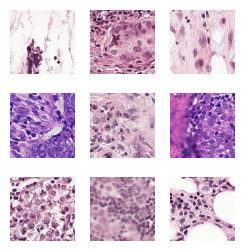

In [13]:
rows, cols = 3, 3

fig, axes = plt.subplots(rows, cols, figsize=(3, 3))

for i in range(3 * 3):
    image = imread(train_path + cancer_images['file'][i])

    row, col = i // cols, i % cols

    axes[row, col].imshow(image)
    axes[row, col].axis('off')

plt.subplots_adjust(wspace = 0.1, hspace = 0.3)

plt.show()

Now we'll generate it for the ones that don't, just for comparison.

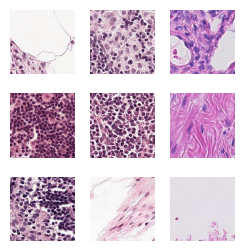

In [14]:
fig, axes = plt.subplots(rows, cols, figsize=(3, 3))

for i in range(3 * 3):
    image = imread(train_path + noncancer_images['file'][i])

    row, col = i // cols, i % cols

    axes[row, col].imshow(image)
    axes[row, col].axis('off')

plt.subplots_adjust(wspace = 0.1, hspace = 0.3)

plt.show()

I personally cannot tell the difference just by looking at the scans. Hopefully the model does a better job.

### Image Preprocessing

Let us load the images so we can use them to train the models.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,  # using 20% of training data for validation
                                  )
validation_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.2,
                                       )

In [19]:
# Awesome HyperParameters!!!
TARGET_SIZE = (64, 64)
BATCH_SIZE = 128
CLASS_MODE = 'binary'  # for two classes; categorical for over 2 classes

# Connecting the ImageDataGenerator objects to our dataset
train_generator = train_datagen.flow_from_dataframe(dataframe=train_data,
                                                    directory=train_path,
                                                    x_col="file",
                                                    y_col="label",
                                                    target_size=TARGET_SIZE,
                                                    subset='training',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode=CLASS_MODE)

validation_generator = validation_datagen.flow_from_dataframe(dataframe=train_data,
                                                              directory=train_path,
                                                              x_col="file",
                                                              y_col="label",
                                                              target_size=TARGET_SIZE,
                                                              subset='validation',
                                                              batch_size=BATCH_SIZE,
                                                              class_mode=CLASS_MODE)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## Model training

It's time to finally train the model.

### Model 1

I've chosen arbitrary numbers as the number of filters. I will later test with different hyperparameters. I'm using SDG as the optimizer for the first model. Since this is a binary classification model, one neuron in the output should be enough.

In [24]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=BATCH_SIZE, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
opt = SGD(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy',AUC()])


# Build the model
model.build(input_shape=(BATCH_SIZE, 64, 64, 3))

# Display the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (128, 62, 62, 32)         896       
                                                                 
 conv2d_21 (Conv2D)          (128, 60, 60, 32)         9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (128, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (128, 28, 28, 64)         18496     
                                                                 
 conv2d_23 (Conv2D)          (128, 26, 26, 64)         36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (128, 13, 13, 64)        0         
 g2D)                                                 

Let us fit this model and see how well it works.

In [25]:
fitted = model.fit(train_generator, validation_data=validation_generator, epochs=7)

Epoch 1/7
1376/1376 [==============================] - 623s 451ms/step - loss: 0.5318 - accuracy: 0.7370 - auc: 0.7993 - val_loss: 0.4904 - val_accuracy: 0.7707 - val_auc: 0.8397
Epoch 2/7
1376/1376 [==============================] - 488s 354ms/step - loss: 0.4582 - accuracy: 0.7896 - auc: 0.8587 - val_loss: 0.4378 - val_accuracy: 0.8001 - val_auc: 0.8728
Epoch 3/7
1376/1376 [==============================] - 353s 256ms/step - loss: 0.4348 - accuracy: 0.8035 - auc: 0.8735 - val_loss: 0.4172 - val_accuracy: 0.8130 - val_auc: 0.8838
Epoch 4/7
1376/1376 [==============================] - 310s 225ms/step - loss: 0.4178 - accuracy: 0.8135 - auc: 0.8841 - val_loss: 0.3987 - val_accuracy: 0.8235 - val_auc: 0.8950
Epoch 5/7
1376/1376 [==============================] - 313s 228ms/step - loss: 0.4090 - accuracy: 0.8177 - auc: 0.8897 - val_loss: 0.3922 - val_accuracy: 0.8272 - val_auc: 0.9003
Epoch 6/7
1376/1376 [==============================] - 315s 229ms/step - loss: 0.3945 - accuracy: 0.8257 

That is interesting. The validation metrics start out better than the ones for training, except for the last epoch. Let us look at this with graphs.

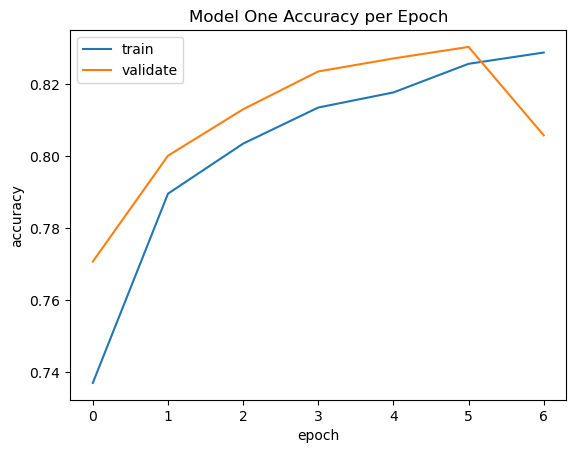

In [26]:
plt.plot(fitted.history['accuracy'])
plt.plot(fitted.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

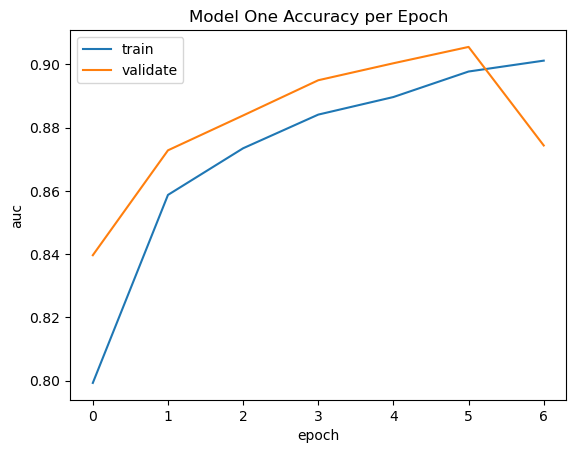

In [27]:
plt.plot(fitted.history['auc'])
plt.plot(fitted.history['val_auc'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

Based on these results, the model best fits the validation data after 6 epoch. Any more than that and it starts to overfit. Let us do the same for a slightly different model.

### Model 2

The architecture for this model is the same, but the number of filters per layer is different to see if less number of filters work better. I also used Adam as the optimizer to see if the model converges faster.

In [33]:
model2 = Sequential()
model2.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu'))
model2.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(units=BATCH_SIZE, activation='relu'))
model2.add(Dense(units=1, activation='sigmoid'))

# Compile the model
opt = Adam(learning_rate=0.01)
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy',AUC()])


# Build the model
model2.build(input_shape=(BATCH_SIZE, 64, 64, 3))

# Display the model summary
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (128, 62, 62, 8)          224       
                                                                 
 conv2d_33 (Conv2D)          (128, 60, 60, 8)          584       
                                                                 
 max_pooling2d_16 (MaxPoolin  (128, 30, 30, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (128, 28, 28, 16)         1168      
                                                                 
 conv2d_35 (Conv2D)          (128, 26, 26, 16)         2320      
                                                                 
 max_pooling2d_17 (MaxPoolin  (128, 13, 13, 16)        0         
 g2D)                                                 

In [34]:
fitted = model2.fit(train_generator, validation_data=validation_generator, epochs=7)

Epoch 1/7
1376/1376 [==============================] - 428s 310ms/step - loss: 0.5801 - accuracy: 0.6941 - auc_4: 0.7507 - val_loss: 0.5069 - val_accuracy: 0.7587 - val_auc_4: 0.8470
Epoch 2/7
1376/1376 [==============================] - 371s 270ms/step - loss: 0.4763 - accuracy: 0.7807 - auc_4: 0.8463 - val_loss: 0.4512 - val_accuracy: 0.7953 - val_auc_4: 0.8651
Epoch 3/7
1376/1376 [==============================] - 362s 263ms/step - loss: 0.4540 - accuracy: 0.7924 - auc_4: 0.8613 - val_loss: 0.4295 - val_accuracy: 0.8092 - val_auc_4: 0.8781
Epoch 4/7
1376/1376 [==============================] - 308s 224ms/step - loss: 0.4344 - accuracy: 0.8057 - auc_4: 0.8734 - val_loss: 0.4250 - val_accuracy: 0.8068 - val_auc_4: 0.8891
Epoch 5/7
1376/1376 [==============================] - 303s 220ms/step - loss: 0.4181 - accuracy: 0.8135 - auc_4: 0.8836 - val_loss: 0.3965 - val_accuracy: 0.8244 - val_auc_4: 0.8963
Epoch 6/7
1376/1376 [==============================] - 305s 222ms/step - loss: 0.4075

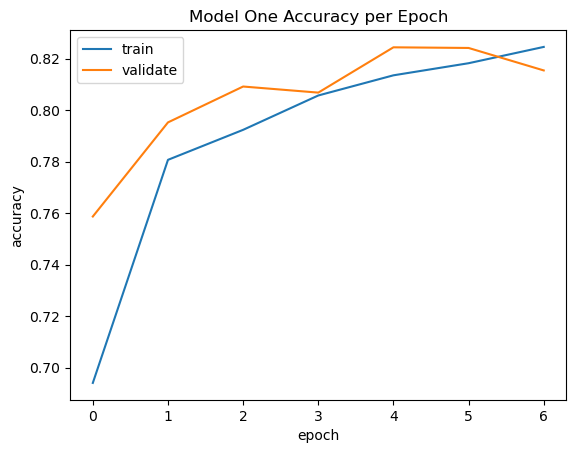

In [35]:
plt.plot(fitted.history['accuracy'])
plt.plot(fitted.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

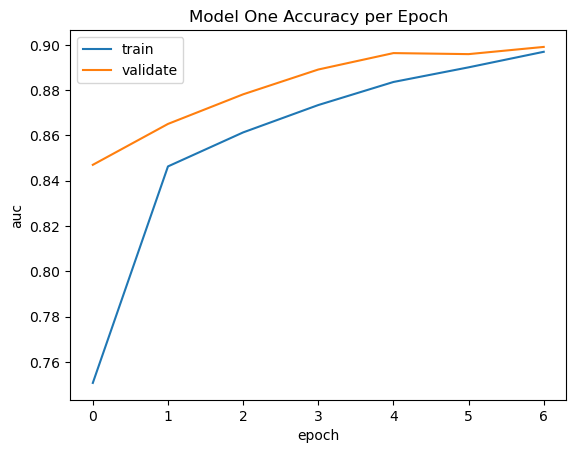

In [38]:
plt.plot(fitted.history['auc_4'])
plt.plot(fitted.history['val_auc_4'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

It appears this model starts out performing better than the previous model for our validation data, but converges slower. This model appears to fit best after 5 epoch, and then starts to overfit.

### Transfer Learning Model

Now let us do something different. We can use an existing model and train it better to see if it performs better than our existing models. For this, I'm going to use the Resnet model to fit the data.

In [62]:
model_resnet = Sequential()
model_resnet.add(ResNet50())
model_resnet.add(Dense(1, activation='sigmoid'))

model_resnet.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy', AUC()])

In [63]:
fit_resnet = model_resnet.fit(train_generator, validation_data=validation_generator, epochs=7)

Epoch 1/7
1376/1376 [==============================] - 400s 279ms/step - loss: 0.6755 - accuracy: 0.5935 - auc_13: 0.5331 - val_loss: 0.6682 - val_accuracy: 0.5961 - val_auc_13: 0.6421
Epoch 2/7
1376/1376 [==============================] - 323s 235ms/step - loss: 0.6504 - accuracy: 0.6135 - auc_13: 0.7453 - val_loss: 0.6147 - val_accuracy: 0.7101 - val_auc_13: 0.8179
Epoch 3/7
1376/1376 [==============================] - 325s 237ms/step - loss: 0.5549 - accuracy: 0.7615 - auc_13: 0.8634 - val_loss: 0.4688 - val_accuracy: 0.8590 - val_auc_13: 0.9095
Epoch 4/7
1376/1376 [==============================] - 323s 234ms/step - loss: 0.4009 - accuracy: 0.8793 - auc_13: 0.9211 - val_loss: 0.3810 - val_accuracy: 0.8587 - val_auc_13: 0.9208
Epoch 5/7
1376/1376 [==============================] - 319s 232ms/step - loss: 0.2986 - accuracy: 0.9070 - auc_13: 0.9492 - val_loss: 0.2731 - val_accuracy: 0.9093 - val_auc_13: 0.9570
Epoch 6/7
1376/1376 [==============================] - 316s 230ms/step - lo

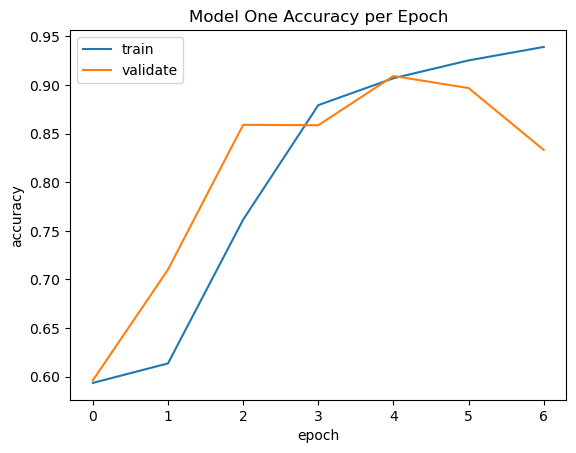

In [64]:
plt.plot(fit_resnet.history['accuracy'])
plt.plot(fit_resnet.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

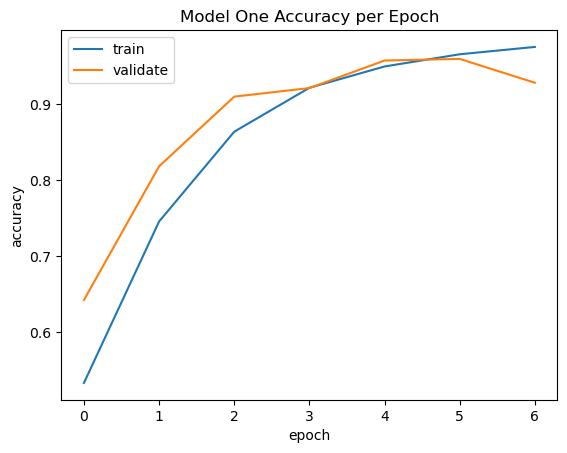

In [65]:
plt.plot(fit_resnet.history['auc_13'])
plt.plot(fit_resnet.history['val_auc_13'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

This model seems to perform not too well in the start, but converges very fast to the point where after 5 epoch, it performs better than the previous models.

### Final Model

Since the Resnet model performs best after 5 epoch, let's train it for up to 5 epoch and use it to predict the test data.

In [66]:
final_fit = model_resnet.fit(train_generator, epochs=5)

Epoch 1/5
1376/1376 [==============================] - 402s 292ms/step - loss: 0.1651 - accuracy: 0.9518 - auc_13: 0.9807
Epoch 2/5
1376/1376 [==============================] - 263s 191ms/step - loss: 0.1402 - accuracy: 0.9601 - auc_13: 0.9849
Epoch 3/5
1376/1376 [==============================] - 255s 186ms/step - loss: 0.1188 - accuracy: 0.9676 - auc_13: 0.9879
Epoch 4/5
1376/1376 [==============================] - 262s 191ms/step - loss: 0.1017 - accuracy: 0.9732 - auc_13: 0.9902
Epoch 5/5
1376/1376 [==============================] - 256s 186ms/step - loss: 0.0882 - accuracy: 0.9780 - auc_13: 0.9920


## Predicting Test Data

Now that we have the model we need, let's use it to predict the test data. We can start by looking at what a sample submission needs to look like.

In [67]:
sample_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


The next few cells predict the labels and save the dataset into a format that is needed.

In [71]:
test_data = pd.DataFrame({'file':os.listdir(test_path)})
test_data.head()

,file
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [82]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_data,
                                                  directory=test_path,
                                                  target_size=TARGET_SIZE,
                                                  x_col="file",
                                                  y_col=None,
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle=False
                                                 )

Found 57458 validated image filenames.


In [83]:
predictions = model_resnet.predict(test_generator)

57458/57458 [==============================] - 480s 8ms/step


In [84]:
submission_df = pd.DataFrame()
submission_df['id'] = test_data['file'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [85]:
submission_df.to_csv('submission.csv',index=False)

## Conclusion

All of the models seemed to perform relatively well, but the Resnet one seemed to perform the best. One of the reasons I didn't see much of a difference between the first two models I trained from scratch is that I didn't significantly change the architecture of the model. I only changed the number of filters and the optimizer. It might be useful to play around with different types of models to see which hyperparameters give the best performance.